# <div style="color:white;display:fill;border-radius:5px;background-color:#015447;letter-spacing:0.1px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;text-align:center">Introduction</p></div>

The **Titanic - Machine Learning from Disaster** competition is one of the simplest competitions in **Kaggle** to learn machine learning. The goal of this competition is to predict the passengers that survived the Titanic crash with the iceberg based on different variables:
- *survival:* if the passenger survived the accident (0 = No, 1 = Yes).
- *pclass:* ticket class for the passenger (1 = 1st (upper), 2 = 2nd (middle), 3 = 3rd (lower)).
- *sex:* the gender of the passenger (female or male).
- *Age:* the age of the passenger in years.
- *sibsp:* the number of siblings (brother, sister, stepbrother, stepsister) and/or spouses (husband, wife) aboard the Titanic.
- *parch:* the number of parents (mother, father) and/or children (daughter, son, stepdaughter, stepson) aboard the Titanic. parch = 0 if the children travelled with the nanny.
- *ticket:* the ticket number.
- *fare:* the passenger fare.
- *cabin:* the cabin number.
- *embarked:* the port where the passenger embarked the Titanic (C = Cherbourg, Q = Queenstown, S = Southampton).

We will use a classification algorithm that outputs a 0 (did not survive) and 1 (survived) based on the survival of the passenger.

##### **Disclaimer**: This notebook is aimed to be part of my learning process in the field of Data Science and Machine Learning. Therefore, I combined my own ideas with other people's solutions that are referenced below:

- https://www.kaggle.com/code/homayoonkhadivi/titanic-eda-model-hyperparameter-tuning-top-5/notebook
- https://www.kaggle.com/code/tanmayunhale/titanic-top-4-hyperparameter-tuning/notebook
- https://www.kaggle.com/code/startupsci/titanic-data-science-solutions
- https://www.kaggle.com/code/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
- https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling
- https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial
- https://www.kaggle.com/code/pedrodematos/titanic-a-complete-approach-for-data-scientists

---

In [73]:
# Import system libraries
import os

# Directory of the project
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Import data wrangling libraries
import numpy as np
import pandas as pd
import scipy

# Import libraries for visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline
import joblib

# Libraries for Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb

import shap

# Local modules
%load_ext autoreload
%autoreload 2
from src import plot_functions, utils

import warnings # Always use at the end after importing all libraries
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Create a color palette
colors = ['darkorchid', 'sandybrown', 'crimson', 'steelblue']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <div style="color:white;display:fill;border-radius:5px;background-color:#015447;letter-spacing:0.1px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;text-align:center">Loading the data</p></div>

Here, the data will be loaded and a first exploratory analysis will be performed to know more about the dataset.

## <b><span style='color:#015447'>Load the train and test sets</span> </b>

In [2]:
# Load the train data
# train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data = pd.read_csv("data/train.csv")
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
# Check shape of train data
train_data.shape

(891, 12)

In [4]:
# Load the test set
# test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data = pd.read_csv("data/test.csv")
test_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [5]:
# Check test set shape
test_data.shape

(418, 11)

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br>The train data has 418 rows and 12 columns, including the <i>target (Survived)</i> variable, while the test set has also 418 rows, but only 11 columns (the <i>target</i> column is missing).
</div>

## <b><span style='color:#015447'>Join the train and test sets</span> </b>

We will join both sets in order to perform feature engineering at a later stage. Then, we will split the data again based on the number of rows since the test data does not have values for the Survived column which is the feature we want to predict.

In [6]:
# Merge both datasets along the rows using *pd.concat* and reset the indices
titanic_data =  pd.concat(objs=[train_data, test_data], axis=0).reset_index(drop=True)

In [7]:
# Create a copy of the titanic_data
titanic_data_copy = titanic_data.copy()

In [8]:
# Check the shape of the merged dataset
titanic_data.shape

(1309, 12)

# <div style="color:white;display:fill;border-radius:5px;background-color:#015447;letter-spacing:0.1px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;text-align:center">Preliminary Data Analysis</p></div>

We will perform a preliminary analysis to figure out the characteristics of the dataset.

## <b><span style='color:#015447'>Data types, unique and null values</span> </b>

Besides identifying the type of data by checking it directly, we must also take into account the number of unique values, as well as the description of the variables. Finally, we will also rename the *Sex* column to *Gender*.

In [9]:
# Check the types of columns in the dataset
titanic_data.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
# Split numerical and object type columns
titanic_cat = titanic_data.select_dtypes(include=object)
titanic_num = titanic_data.select_dtypes(exclude=object)

In [11]:
# Check the unique values of each column
titanic_num.nunique()

PassengerId    1309
Survived          2
Pclass            3
Age              98
SibSp             7
Parch             8
Fare            281
dtype: int64

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>Initially, it seems that there are 7 numerical columns and 5 categorical ones. However, it must be taken into account that the <i>PassengerId</i> column does not contain useful information.<br><br>Secondly, the <i>Survived</i> variable is a binary categorical variable with only two unique values (0 or 1).<br><br>Thirdly, the <i>Pclass</i> variable is also an encoded categorical which can take three unique values (1, 2 or 3), depending on the passenger class (<i>Upper, Middle or Lower</i>).<br><br>In conclusion, there are only 4 real numerical variables (<i>Age, SibSp, Parch</i> and <i>Fare</i>).</div>


In [12]:
# Check for Null values on the whole dataset
titanic_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br>
<ul>
  <li>The <i>Survived</i> variable has 418 null values which correspond to the test data. Therefore, there is no need to fill them.</li>
  <li>The <i>Age</i> variable has 256 null values, the <i>Fare</i> variable only 1, the <i>Cabin</i> column has 1014 nulls and the <i>Embarked</i> column only 2.</li>
</ul> 
The missing values will be filled later.
</div>

In [13]:
# Rename the Sex column to Gender
titanic_data.rename(columns={'Sex':'Gender'}, inplace=True)

# <div style="color:white;display:fill;border-radius:5px;background-color:#015447;letter-spacing:0.1px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;text-align:center">New variables</p></div>

In this section, we will create new variables from existing ones to obtain more useful information that helps in predicting the survival rate.

## <b><span style='color:#015447'>*Status*</span> </b>

Although the *Name* column may seem that holds no information, the title actually identifies each person by their social status and this could have an impact on the probability to survive.

In [14]:
# Filter the Name variable to get the titles
titanic_data['Title'] = titanic_data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [15]:
# Show the unique values of the Title variable
titanic_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>There are 18 different titles so it seems a good idea to classify them in smaller groups that provide useful information. For instance, we can group some of the titles by <i>Nobility</i> and <i>Officers</i>. The remaining titles will be grouped together into a category named <i>Regular</i>. </div>

In [16]:
# Create lists that contain the titles for the three categories
nobility = ['Lady', 'the Countess','Don', 'Sir', 'Jonkheer', 'Dona']
officers = ['Capt', 'Col','Major', 'Dr', 'Rev']
regular = ['Mlle', 'Ms', 'Mrs', 'Miss', 'Mme', 'Master', 'Mr']

# Create new column called status based on the values of the Title column
titanic_data['Status'] = titanic_data['Title'].mask(titanic_data['Title'].isin(nobility), 'Nobility'
                                             ).mask(titanic_data['Title'].isin(officers), 'Officers'
                                             ).mask(titanic_data['Title'].isin(regular), 'Regular')

# Drop title and name columns
titanic_data.drop(['Title', 'Name'], axis=1, inplace=True)

In [17]:
# Check unique values of the Status column
titanic_data['Status'].unique()

array(['Regular', 'Nobility', 'Officers'], dtype=object)

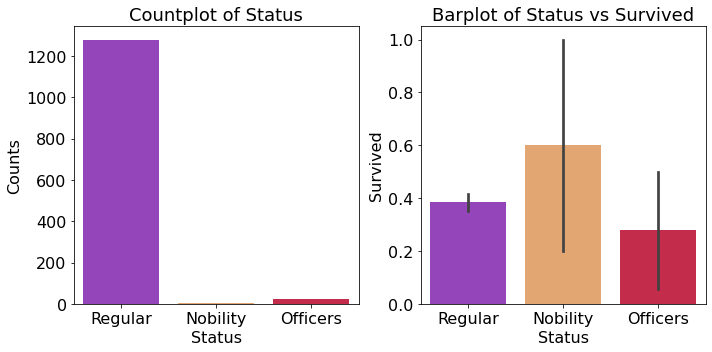

In [18]:
# Create plots for Status
plot_functions.plot_barcharts(titanic_data, 'Status', 'Survived', None, colors, 2, (10,5))

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>There were more than 1200 regular passengers, while very little officers and even less nobles. From those, only around 40% of regular passengers, about 60% of nobility and 30% officers survived. However, it must also be emphasized that there is a large dispersion in the <i>Survived %</i> of the last two. </div>

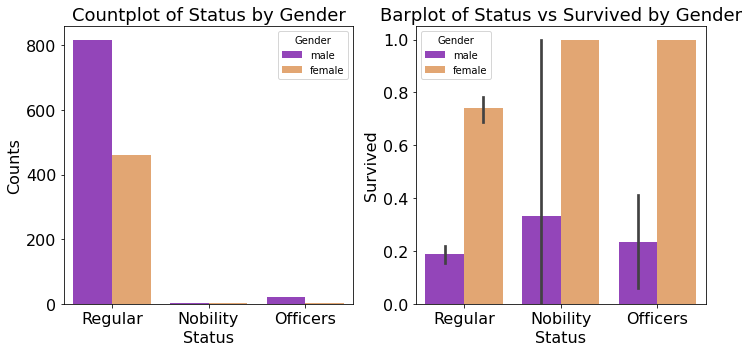

In [19]:
# Create plots for Status by Gender
plot_functions.plot_barcharts(titanic_data, 'Status', 'Survived', 'Gender', colors, 2, (10,5))

In [20]:
# Calculate Status vs Gender
pd.crosstab(titanic_data['Status'], titanic_data['Gender']).transpose()

Status,Nobility,Officers,Regular
Gender,,,
female,3,1,462
male,3,22,818


<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>The <i>Status</i> variable based on <i>Gender</i> shows that there were almost two times more male than female <i>Regular</i> passengers, the same amount for <i>Nobility</i> and only one female <i>Officer</i>. However, if we look at the <i>Survived %</i>, female survival rate was above 70 % for the <i>Regular</i> passengers and 100 % for the others. In contrast, male survival rate was only between 20 and 30 %.</div>

## <b><span style='color:#015447'>*Decks*</span> </b>

The feature *Cabin* could be used for prediction purposes after performing some feature engineering on it since the location of the cabin may have had an influence on the possibility to be saved from the sinking.

In [21]:
titanic_data['Cabin'].value_counts()

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F33                4
                  ..
A14                1
E63                1
E12                1
E38                1
C105               1
Name: Cabin, Length: 186, dtype: int64

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>All the values of the <i>Cabin</i> variable start with a letter followed by a number. We also see that in some cases there is different letter/number combinations. This could indicate people traveling together that were assigned any of the cabins as seen in the value counts.<br><br>As explained in [encyclopedia-titanica](https://www.encyclopedia-titanica.org/deck-plan-key.html), the first letter corresponds to the *<i>Deck</i> each cabin was located. Therefore, it seems possible that the passengers that where on decks closer to the exits or boats, could have more chances of survival. So, let's filter by the first letter of the <i>Cabin</i> and create a new variable (<i>Deck</i>). Also, the null values will be assigned to the value <i>UNKN</i>.

In [22]:
# Create an empty list
deck_letter = []

# Loop through the *Cabin* row values
for row in titanic_data['Cabin']:
    if not pd.isnull(row):
        deck_letter.append(row[0])
    else:
        deck_letter.append('UNKN')

In [23]:
# Drop the *Cabin* column
titanic_data.drop('Cabin', axis=1, inplace=True)

In [24]:
# Assign list to dataframe column
titanic_data['Deck'] = deck_letter
titanic_data['Deck'].unique()

array(['UNKN', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [25]:
# Group the passengers by Deck and calculate the number of passengers by class in %
passengers_deck = titanic_data.groupby('Deck')['Pclass'].value_counts(normalize=True)
passengers_deck = passengers_deck.mul(100).rename('Percent').reset_index()

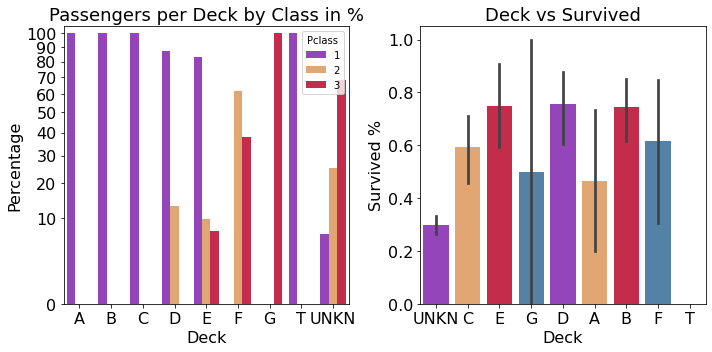

In [26]:
# Plot passengers by Deck
figs, axs = plt.subplots(ncols = 2, figsize = (10,5))

# Deck barplot
sns.barplot(x='Deck', y='Percent', hue='Pclass', data=passengers_deck, ax=axs[0], palette=colors[:-1])
axs[0].set_title('Passengers per Deck by Class in %', fontsize=18)
axs[0].set_ylabel('Percentage', fontsize=16)


# Function x**(1/2) for Y-axis scale
# Source: https://matplotlib.org/stable/gallery/scales/scales.html#sphx-glr-gallery-scales-scales-py
def forward(x):
    return x**(1/2)

def inverse(x):
    return x**2

# Set y-axis scale
axs[0].set_yscale('function', functions=(forward, inverse))
axs[0].yaxis.set_major_locator(FixedLocator(np.arange(0, 101, 10)**2))
axs[0].yaxis.set_major_locator(FixedLocator(np.arange(0, 101, 10)))


# Deck vs Survived
sns.barplot(x='Deck', y='Survived', data=titanic_data, ax = axs[1], palette=colors)
axs[1].set_title('Deck vs Survived', fontsize=18)
axs[1].set_ylabel('Survived %', fontsize=16)

for i in range(0, 2):
    axs[i].tick_params(labelsize=16)
    axs[i].set_xlabel('Deck', fontsize=16)
    
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>Decks A, B, C and T only have passengers from the first class, so we can group them together in a single category named <i>ABCT</i>. Decks D and E have similar percentages of classes and equivalent survival rates, so they will also be grouped together in a category named <i>DE</i>. The remaining decks will be left as they are since the distributions shown are different.</div>

In [27]:
# Group decks following previous criteria
titanic_data['Deck'] = titanic_data['Deck'].mask(titanic_data['Deck'].isin(['A', 'B', 'C', 'T']), 'ABCT'
                                             ).mask(titanic_data['Deck'].isin(['D', 'E']), 'DE')

In [28]:
# Check unique values of the Deck column
titanic_data['Deck'].unique()

array(['UNKN', 'ABCT', 'DE', 'G', 'F'], dtype=object)

## <b><span style='color:#015447'>*Family groups*</span> </b>

The features *SibSp* and *Parch* could be used to create a new variable (<i>Family Group</i>) that could be used to predict the survival rate.

To create the family groups, we must first know the number of siblings and parents that each passenger had. Therefore, we must add the <i>SibSp</i> and <i>Parch</i> variables. In addition, since values of 0 indicate that the passenger had no siblings or parents and the family group should be at least formed by one member, we will add 1 to the sum of the <i>SibSp</i> and <i>Parch</i> variables.

In [29]:
# Sum values of SibSp and Parch + 1
sum_sibsp_parch = titanic_data['SibSp'] + titanic_data['Parch'] + 1

# Show value counts of the sum_sibsp_parch column
sum_sibsp_parch.value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
dtype: int64

We will split the different family groups into 4 groups: <i>A</i> (Alone if there is only 1 member), <i>S</i> (Small between 2 and 3 members), <i>M</i> (Medium between 4 and 6 members) and <i>L</i> (Large for more than 6 members).

In [30]:
# Create Family group column based on the sum of SibSp and Parch
titanic_data['Family Group'] = sum_sibsp_parch.apply(utils.fam_vals)

In [31]:
# Check unique values of the Family Group column
titanic_data['Family Group'].value_counts()

A    790
S    394
M     90
L     35
Name: Family Group, dtype: int64

In [32]:
# Drop the *SibSp* and *Parch* columns
titanic_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

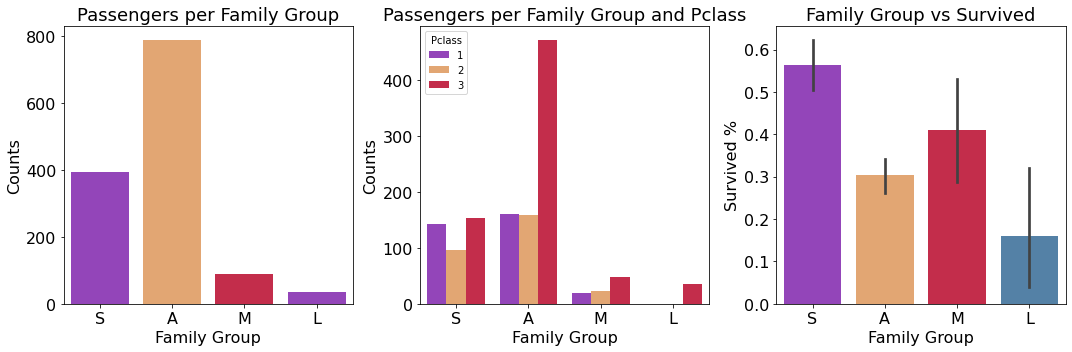

In [33]:
# Plot passengers by Family Group
figs, axs = plt.subplots(ncols = 3, figsize = (15,5))

# Family group countplot
sns.countplot(x='Family Group', data=titanic_data, ax=axs[0], palette=colors[:-1])
axs[0].set_title('Passengers per Family Group', fontsize=18)
axs[0].set_ylabel('Counts', fontsize=16)

# Family group countplot per class
sns.countplot(x='Family Group', hue='Pclass', data=titanic_data, ax=axs[1], palette=colors[:-1])
axs[1].set_title('Passengers per Family Group and Pclass', fontsize=18)
axs[1].set_ylabel('Counts', fontsize=16)

# Family group vs Survived
sns.barplot(x='Family Group', y='Survived', data=titanic_data, ax = axs[2], palette=colors)
axs[2].set_title('Family Group vs Survived', fontsize=18)
axs[2].set_ylabel('Survived %', fontsize=16)

for i in range(0, 3):
    axs[i].tick_params(labelsize=16)
    axs[i].set_xlabel('Family Group', fontsize=16)
    
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>There were many passengers traveling alone and also small families, while there very few medium and large families (more than 3 members).<br><br>In addition, small families are quite balanced for the three classes, while people that traveled alone are predominant in the third class. Medium and large families also have more representation in the third class.<br><br>Finally, small families had much more chances to survive compared to people traveling alone or medium families, whereas large families had the lowest survival rate, especially, considering that they were mostly from the third class.</div>

# <div style="color:white;display:fill;border-radius:5px;background-color:#015447;letter-spacing:0.1px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;text-align:center">Exploratory Data Analysis</p></div>

## <b><span style='color:#015447'>Categorical Features Analysis</span> </b>

In this section, we will analyze the remaining categorical features and their relations, also with the target variable.

### <b><span style='color:#015447'>Pclass</span> </b>

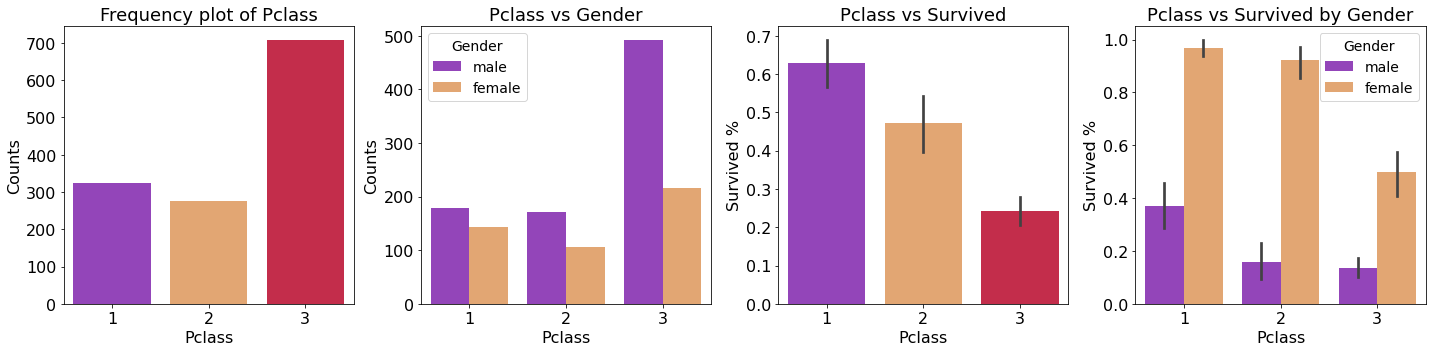

In [34]:
# Create the figure
figs, axs = plt.subplots(ncols = 4, figsize = (20,5))

# Pclass countplot
sns.countplot(x='Pclass', data=titanic_data, ax=axs[0], palette=colors)
axs[0].set_title('Frequency plot of Pclass', fontsize=18)
axs[0].set_ylabel('Counts', fontsize=16)

# Pclass vs Gender
sns.countplot(x='Pclass', hue='Gender', data=titanic_data, ax = axs[1], palette=colors)
axs[1].set_title('Pclass vs Gender', fontsize=18)
axs[1].legend(title='Gender', fontsize=14, title_fontsize=14)
axs[1].set_ylabel('Counts', fontsize=16)

# Pclass vs Survived
sns.barplot(x='Pclass',y='Survived', data=titanic_data, ax = axs[2], palette=colors)
axs[2].set_title('Pclass vs Survived', fontsize=18)
axs[2].set_ylabel('Survived %', fontsize=16)

# Pclass vs Survived by Gender
sns.barplot(x='Pclass',y='Survived', hue='Gender', data=titanic_data, ax = axs[3], palette=colors)
axs[3].set_title('Pclass vs Survived by Gender', fontsize=18)
axs[3].legend(title='Gender', fontsize=14, title_fontsize=14)
axs[3].set_ylabel('Survived %', fontsize=16)

for i in range(0, 4):
    axs[i].tick_params(labelsize=16)
    axs[i].set_xlabel('Pclass', fontsize=16)
    
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>The <i>Pclass</i> variable has an unbalanced representation of passengers with the majority of them (~700) being from the <i>lower</i> class, while <i>upper</i> and <i>middle</i> classes had only around 300 passengers each. If we take into account the <i>Gender</i> dimension of the dataset, we can see that all classes had more male than female traveling. However, first and second classes are quite balanced, while for the third class there is a large imbalance with only around 30% being female.<br><br>If we consider the passengers that survived from each class (only represented by the train data), it can be seen that those who had more chances to survive were from the first class with approximately a 60% of survival rate, the second class had almost 50% of survival rate, while the third class had less chances to survive with aroud 25% survival rate. This shows how the poor were the less favored when selecting which individuals had to be saved.<br><br>A similar trend is seen if we split the <i>Pclass</i> survival rate by <i>Gender</i> (only represented by the train data), where again females had the highest chance to survive in all classes. It is also enlightening how rich males had a survival rate larger than both <i>middle</i> and <i>lower</i> class passengers, which again shows the inequality between social classes.</div>

### <b><span style='color:#015447'>Gender</span> </b>

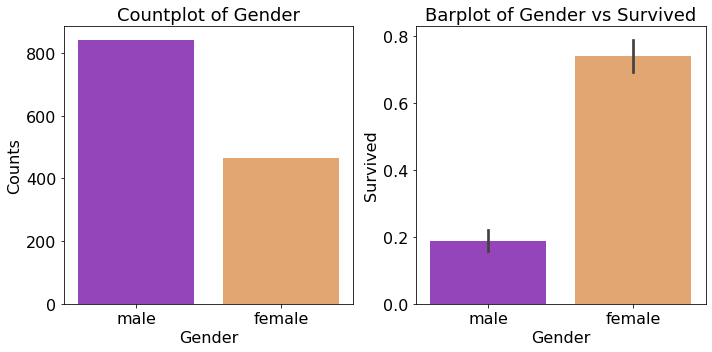

In [35]:
plot_functions.plot_barcharts(titanic_data, 'Gender', 'Survived', None, colors, 2, (10,5))

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>There were around 450 females aboard of the Titanic, while about the double amount of male (~850). However, only around 20% of male survived the sinking, while almost 80% of female did.</div>

### <b><span style='color:#015447'>Embarked</span> </b>

Besides the analysis of the variable, we will also fill the missing values found before. Since, there are only 2 values and this variable is categorical, we will use a simple imputation method by the most common value.

In [36]:
# Find the most common value from the Embarked variable (mode)
embarked_mode = titanic_data['Embarked'].mode()
print('The most common value from the Embarked variable is: ', embarked_mode)

The most common value from the Embarked variable is:  0    S
Name: Embarked, dtype: object


In [37]:
# Fill the missing values with the mode
titanic_data['Embarked'] = titanic_data['Embarked'].fillna(embarked_mode[0])

# Check missing values for the Embarked column
pd.isnull(titanic_data['Embarked']).sum()

0

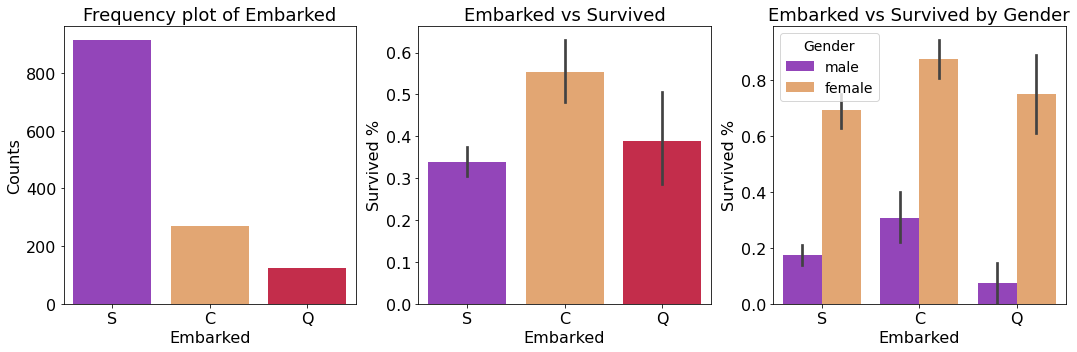

In [38]:
# Create the figure
figs, axs = plt.subplots(ncols = 3, figsize = (15,5))

# Embarked countplot
sns.countplot(x='Embarked', data=titanic_data, ax=axs[0], palette=colors)
axs[0].set_title('Frequency plot of Embarked', fontsize=18)
axs[0].set_ylabel('Counts', fontsize=16)

# Embarked vs Survived
sns.barplot(x='Embarked', y='Survived', data=titanic_data, ax = axs[1], palette=colors)
axs[1].set_title('Embarked vs Survived', fontsize=18)
axs[1].set_ylabel('Survived %', fontsize=16)

# Embarked vs Survived by Gender
sns.barplot(x='Embarked', y='Survived', hue='Gender', data=titanic_data, ax = axs[2], palette=colors)
axs[2].set_title('Embarked vs Survived by Gender', fontsize=18)
axs[2].set_ylabel('Survived %', fontsize=16)
axs[2].legend(title='Gender', fontsize=14, title_fontsize=14, loc=2)

for col in range(0, 3):
    axs[col].tick_params(labelsize=16)
    axs[col].set_xlabel('Embarked', fontsize=16)
    
plt.tight_layout()
plt.show()

In [39]:
# Create dimensions
pclass_dim = go.parcats.Dimension(values=titanic_data['Pclass'], categoryorder='category ascending', label='Pclass')

gender_dim = go.parcats.Dimension(values=titanic_data['Gender'], label='Gender')

embarked_dim = go.parcats.Dimension(values=titanic_data['Embarked'], label="Embarked")

# Create parcats
                   
fig = go.Figure(data = [go.Parcats(dimensions=[pclass_dim, gender_dim, embarked_dim],
        hoverinfo='count+probability',
        labelfont={'size': 18, 'family': 'Times'},
        tickfont={'size': 16, 'family': 'Times'},
        arrangement='freeform')])

fig.show()

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>Most of the passengers from the Titanic (~850) boarded the ship at Southampton, while around 200 boarded it at Cherbourg and 100 in Queenstown. The survival rate for the passengers that boarded the ship is 35% for Southampton, 55% for Cherbourg and 40% for Queenstown. If we consider the gender dimension of the survivors, 70% of female that boarded the Titanic at Southampton survived, while only 20% of male did. For those that boarded at Cherbourg, close to 90% of female survived, whereas only around 30% male did. Finally, from those that started their journey at Queenstown, close to 80% female survived and about 10% male.<br><br>If we consider the class of the tickets, we can see that most females and males that boarded at Southampton had third and second class tickets. We can also see a similar pattern for first class tickets. Chersbourg had a predominance of passengers that bought first and third class tickets. Finally, the majority of passengers that boarded in Queenstown had third class tickets.

## <b><span style='color:#015447'>Encoding categorical features</span> </b>

Before proceeding with the analysis of numerical variables, we will encode the categorical features since there may be important correlations that will help us to understand the data and during the modeling. One-hot encoding will be used to encode the categorical features.

In [40]:
# Create a list of categorical variables
cat_vars = ['Pclass', 'Gender', 'Embarked', 'Status', 'Deck', 'Family Group']

# Create a new dataframe to concatenate the original dataframe with the encoded variables
titanic_data_ohe = titanic_data.copy()

In [41]:
# Call the encode_categorical_variables function from the utils.py file
titanic_data_ohe = utils.encode_categorical_variables(titanic_data_ohe, cat_vars)

In [42]:
# Check the new dataframe
titanic_data_ohe.head()

,PassengerId,Survived,Age,Ticket,Fare,Pclass_1,Pclass_2,Pclass_3,Gender_female,Gender_male,...,Status_Regular,Deck_ABCT,Deck_DE,Deck_F,Deck_G,Deck_UNKN,Family Group_A,Family Group_L,Family Group_M,Family Group_S
0,1,0.0,22.0,A/5 21171,7.2500,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2,1.0,38.0,PC 17599,71.2833,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,1.0,26.0,STON/O2. 3101282,7.9250,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,4,1.0,35.0,113803,53.1000,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,0.0,35.0,373450,8.0500,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [43]:
# Check tail of the dataframe
titanic_data_ohe.tail()

,PassengerId,Survived,Age,Ticket,Fare,Pclass_1,Pclass_2,Pclass_3,Gender_female,Gender_male,...,Status_Regular,Deck_ABCT,Deck_DE,Deck_F,Deck_G,Deck_UNKN,Family Group_A,Family Group_L,Family Group_M,Family Group_S
1304,1305,NaN,NaN,A.5. 3236,8.0500,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1305,1306,NaN,39.0,PC 17758,108.9000,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1306,1307,NaN,38.5,SOTON/O.Q. 3101262,7.2500,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1307,1308,NaN,NaN,359309,8.0500,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1308,1309,NaN,NaN,2668,22.3583,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [44]:
# Check that the values match with the original dataframe
titanic_data.head()

,PassengerId,Survived,Pclass,Gender,Age,Ticket,Fare,Embarked,Status,Deck,Family Group
0,1,0.0,3,male,22.0,A/5 21171,7.2500,S,Regular,UNKN,S
1,2,1.0,1,female,38.0,PC 17599,71.2833,C,Regular,ABCT,S
2,3,1.0,3,female,26.0,STON/O2. 3101282,7.9250,S,Regular,UNKN,A
3,4,1.0,1,female,35.0,113803,53.1000,S,Regular,ABCT,S
4,5,0.0,3,male,35.0,373450,8.0500,S,Regular,UNKN,A


In [45]:
# Check tail of the original dataframe
titanic_data.tail()

,PassengerId,Survived,Pclass,Gender,Age,Ticket,Fare,Embarked,Status,Deck,Family Group
1304,1305,NaN,3,male,NaN,A.5. 3236,8.0500,S,Regular,UNKN,A
1305,1306,NaN,1,female,39.0,PC 17758,108.9000,C,Nobility,ABCT,A
1306,1307,NaN,3,male,38.5,SOTON/O.Q. 3101262,7.2500,S,Regular,UNKN,A
1307,1308,NaN,3,male,NaN,359309,8.0500,S,Regular,UNKN,A
1308,1309,NaN,3,male,NaN,2668,22.3583,C,Regular,UNKN,S


## <b><span style='color:#015447'>Numerical Features Analysis</span> </b>

In this section, we will analyze the different numerical features and their relations, also with the target variable.

### <b><span style='color:#015447'>Age</span> </b>
In addition to the analysis of the variable, we will also fill the 263 missing values found before. To do so, we must find which variables are more useful.

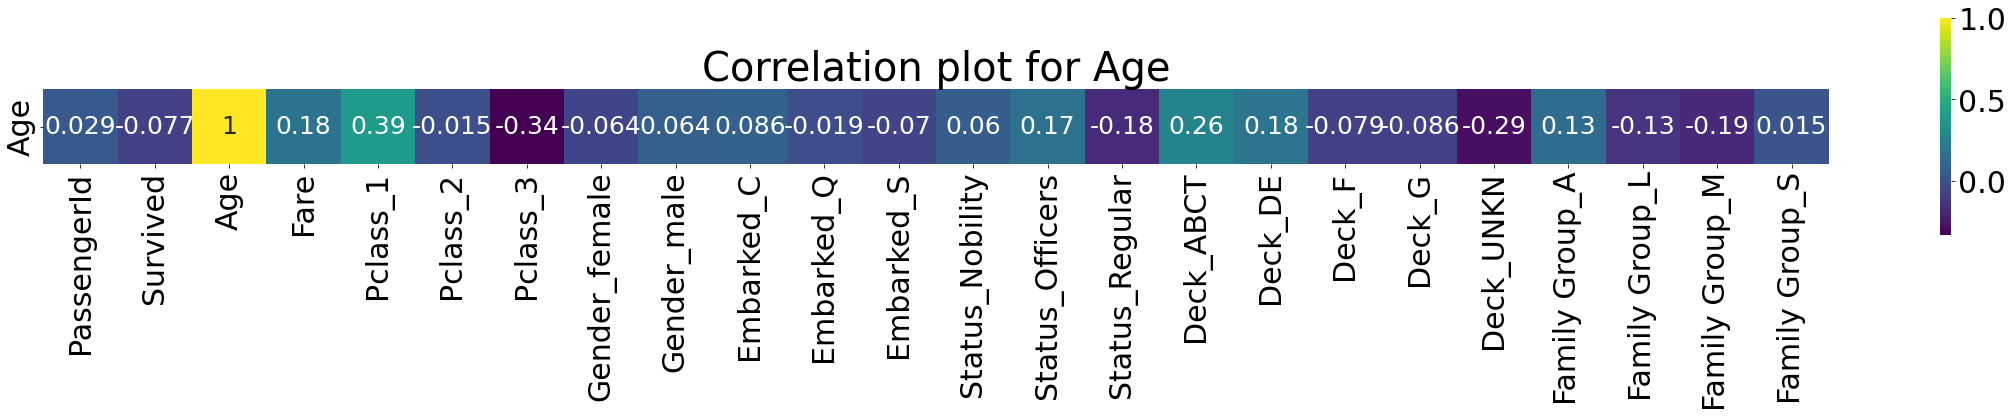

In [46]:
# Correlation plot for the 'Age' variable
age_corr = plot_functions.correlation_single_variable(titanic_data_ohe, 'Age')

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>It seems that there is a relatively moderate correlation of <i>Age</i> with the encoded variables: <i>Fare</i>, <i>Pclass_2</i>, <i>Pclass_3</i>, <i>Status_Nobility</i>, <i>Status_Officers</i>, <i>Deck_UNKN</i>, <i>Deck_ABCT</i>, <i>Deck_F</i>, <i>Family Group_S</i>, <i>Family Group_A</i> and <i>Family Group_M</i> Hence, we can try imputing the <i>Age</i> values using the <i>KNNImputer</i> method from the <i>scikit-learn</i> library, and these variables.

In [47]:
# Create list for age using the create_var_list function from the utils.py file
age_list = utils.create_var_list(age_corr, 'Age', 0.1)

In [48]:
# Impute the Age variable using the knn_imputation function from the utils.py file
titanic_data_ohe_imp = utils.knn_imputation(titanic_data_ohe, age_list, 'Age', 5)

# Check the new dataframe
titanic_data_ohe_imp.head()

,PassengerId,Survived,Age,Ticket,Fare,Pclass_1,Pclass_2,Pclass_3,Gender_female,Gender_male,...,Status_Regular,Deck_ABCT,Deck_DE,Deck_F,Deck_G,Deck_UNKN,Family Group_A,Family Group_L,Family Group_M,Family Group_S
0,1,0.0,22.0,A/5 21171,7.2500,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2,1.0,38.0,PC 17599,71.2833,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,1.0,26.0,STON/O2. 3101282,7.9250,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,4,1.0,35.0,113803,53.1000,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,0.0,35.0,373450,8.0500,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [49]:
titanic_data.head()

,PassengerId,Survived,Pclass,Gender,Age,Ticket,Fare,Embarked,Status,Deck,Family Group
0,1,0.0,3,male,22.0,A/5 21171,7.2500,S,Regular,UNKN,S
1,2,1.0,1,female,38.0,PC 17599,71.2833,C,Regular,ABCT,S
2,3,1.0,3,female,26.0,STON/O2. 3101282,7.9250,S,Regular,UNKN,A
3,4,1.0,1,female,35.0,113803,53.1000,S,Regular,ABCT,S
4,5,0.0,3,male,35.0,373450,8.0500,S,Regular,UNKN,A


In [50]:
# Check missing values for the Age column
pd.isnull(titanic_data_ohe_imp['Age']).sum()

0

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>The missing values were in the <i>Age</i> variable were filled correctly. So, we can proceed with the analysis.</div>

In [51]:
# Define the hue_list to use to plot the histograms
hue_list = ['Gender', 'Pclass', 'Embarked', 'Status', 'Deck', 'Family Group']

6


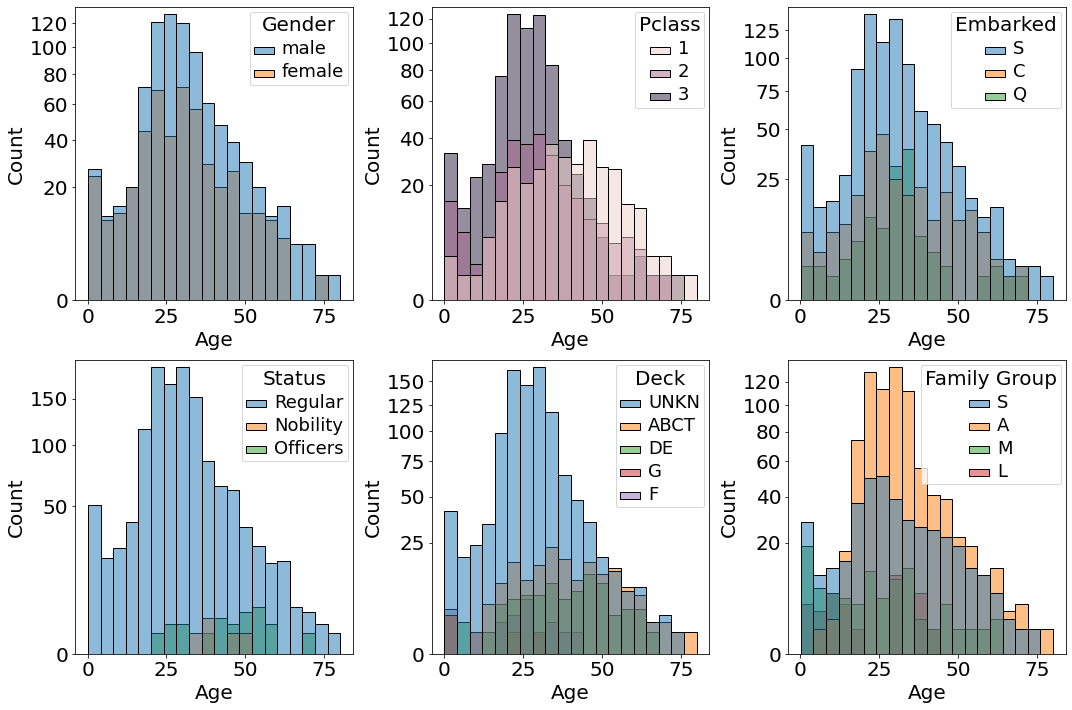

In [52]:
# Plot the histograms using the plot_histograms function from the plot_functions.py file
plot_functions.plot_histograms(df_ohe = titanic_data_ohe_imp, df_original = titanic_data, x_label = 'Age', hue = hue_list, colors = colors, figsize = (15,10), bins = 20)

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>The <i>Age</i> distributions for the <i>Gender</i>, <i>Embarked</i> and <i>Family Group</i> variables are very similar with a median close to 25-30 years old.<br><br>For the <i>Pclass</i>, the <i>Age</i> is slightly lower for the second and third classes as compared to the first one.<br><br>For the <i>Status</i>, the <i>Age</i> is quite lower for the <i>Regular</i> category as compared to the other two.<br><br>Finally, the <i>Age</i> distribution for the <i>Deck</i> variable is lower for the <i>UNKN</i> category as compared to the other categories.

### <b><span style='color:#015447'>*Fare*</span> </b>

Let's focus first on the *Fare* variable which has only 1 missing value. We will get the row information for it.

In [53]:
# Get row info for missing value
titanic_data_ohe_imp.loc[titanic_data_ohe_imp['Fare'].isnull()]

,PassengerId,Survived,Age,Ticket,Fare,Pclass_1,Pclass_2,Pclass_3,Gender_female,Gender_male,...,Status_Regular,Deck_ABCT,Deck_DE,Deck_F,Deck_G,Deck_UNKN,Family Group_A,Family Group_L,Family Group_M,Family Group_S
1043,1044,NaN,60.5,3701,NaN,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>The missing value for the <i>Fare</i> variable corresponds to <i>PassengerID=1044</i> which is part of the <i>test data</i>. His name was <i>Thomas Storey</i> (60.5 years old) and belonged to the <i>third</i> class. He traveled alone and boarded the Titanic at Southampton. The <i>Deck</i> is also unknown.

We can use the the <i>knn_imputation</i> function defined before to fill the <i>Fare</i>.</div>

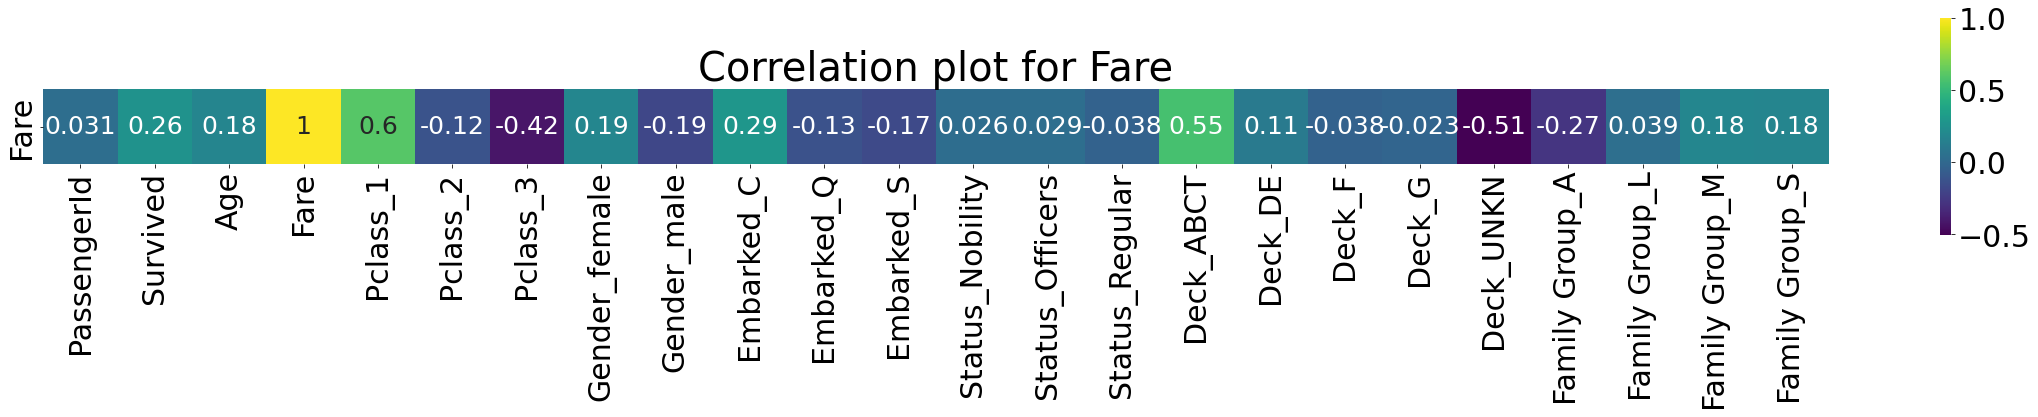

In [54]:
# Correlation plot for the 'Fare' variable
fare_corr = plot_functions.correlation_single_variable(titanic_data_ohe, 'Fare')

In [55]:
# Create list for Fare
fare_list = utils.create_var_list(fare_corr, 'Fare', 0.1)

In [56]:
# Impute the Fare variable
titanic_data_ohe_imp = utils.knn_imputation(titanic_data_ohe_imp, fare_list, 'Fare', 5)

# Get row info for the passenger
titanic_data_ohe_imp.loc[titanic_data_ohe_imp['PassengerId']==1044]

,PassengerId,Survived,Age,Ticket,Fare,Pclass_1,Pclass_2,Pclass_3,Gender_female,Gender_male,...,Status_Regular,Deck_ABCT,Deck_DE,Deck_F,Deck_G,Deck_UNKN,Family Group_A,Family Group_L,Family Group_M,Family Group_S
1043,1044,NaN,60.5,3701,12.8075,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


6


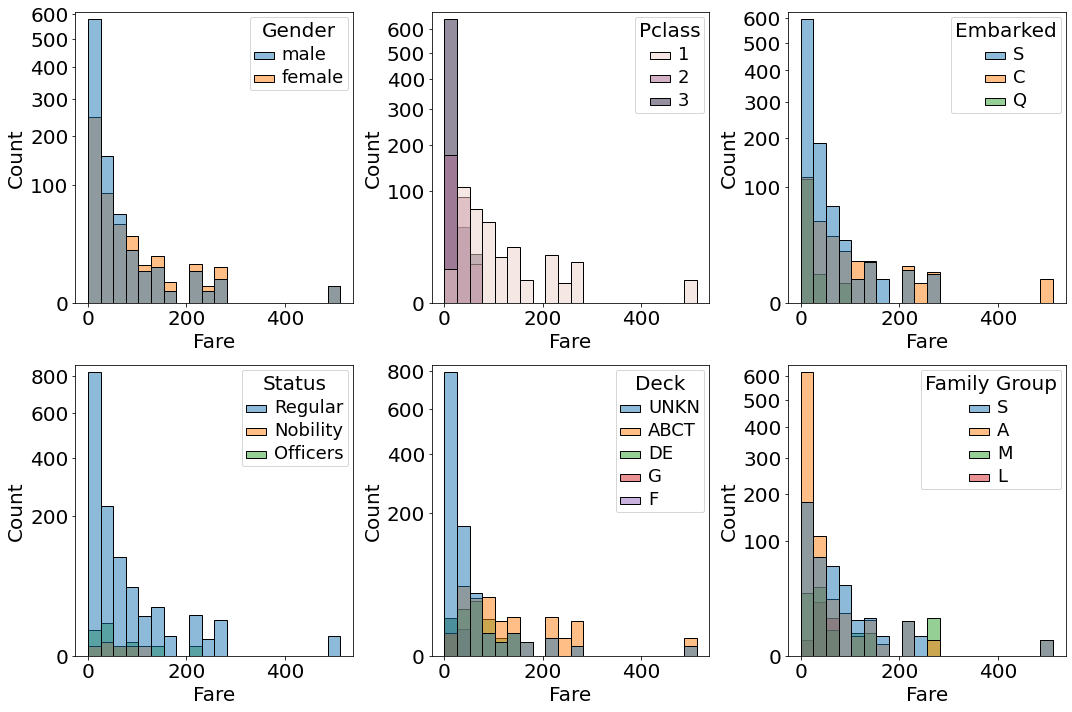

In [57]:
# Plot the histograms using the plot_histograms function from the plot_functions.py file
plot_functions.plot_histograms(df_ohe = titanic_data_ohe_imp, df_original = titanic_data, x_label = 'Fare', hue = hue_list, colors = colors, figsize = (15,10), bins = 20)

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>Most of the passengers paid low <i>Fares</i>. However, it is true that first class passengers paid higher <i>Fares</i>, which is also correlated with the <i>Decks</i> where they were located (<i>ABCT</i> and <i>DE</i>). It also seems that some passengers with a <i>Regular</i> status paid higher <i>Fares</i> than those with a <i>Nobility</i> or <i>Officers</i> status. The <i>Fare</i> distribution for the <i>Embarked</i> variable is also higher for the <i>Cherbourg</i> category as compared to the other categories. Finally, the <i>Fare</i> distribution for the <i>Family Group</i> variable is also higher for families with more members.</div>

## <b><span style='color:#015447'>Target variable (Survived)</span> </b>

In this section, we will analyze the target variable (Survived) to understand the distribution of values.

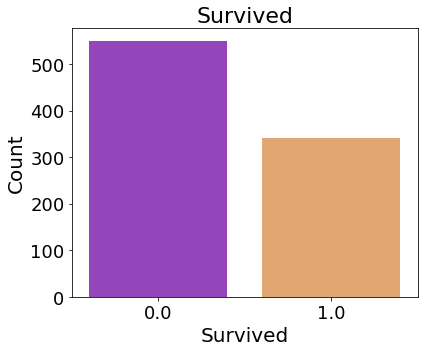

In [58]:
# Plot the Survived distribution
fig = plt.figure(figsize=(6,5))
sns.countplot(data=titanic_data_ohe_imp, x='Survived', palette=colors)

# Customize the plot
plt.title('Survived', fontsize=22)
plt.xlabel('Survived', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>The target variable is quite unbalanced with a higher representation of values associated with non-survivors for the Titanic sinking. This must be taken into account during the modeling process to avoid any bias during the training and cross-validation steps. Therefore, <i>Stratified K-fold cross-validation</i> will be used in order to preserve the ratio for each class in the different folds, allowing a better comparison and delivering equivalent metric performances between them.</div>

# <div style="color:white;display:fill;border-radius:5px;background-color:#015447;letter-spacing:0.1px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;text-align:center">Modeling</p></div>

Now that we already have the data prepared and we have the different variables, we can split it into train and test sets to proceed with the modeling. Here, we will compare the following algorithms to see which one performs better:

* Logistic regression
* KNN
* SVC
* Random Forest Classifier
* XGBoost Classifier

We will also use a *stratified K-fold cross-validation* method to evaluate the performance of each model as mentioned before.


In [59]:
# Drop PassengerId and Ticket columns
titanic_data_ohe_imp = titanic_data_ohe_imp.drop(['PassengerId', 'Ticket'], axis=1)

In [60]:
# Split data into train and test
train = titanic_data_ohe_imp.loc[titanic_data_ohe_imp['Survived'].notnull()]
test = titanic_data_ohe_imp.loc[titanic_data_ohe_imp['Survived'].isnull()]


Let's create a train / validation split of the data to evaluate the different models.

In [61]:
# Split the data into train and validation using the train_test_split function from the sklearn.model_selection module
# X_train, X_val, y_train, y_val = train_test_split(train.drop('Survived', axis=1), train['Survived'], test_size=0.2, random_state=42)

In [62]:
# Split train and test into X and y
X_train = train.drop(['Survived'], axis=1)
y_train = train['Survived']

X_test = test.drop(['Survived'], axis=1)

In [79]:
# Define random state
random_state = 42

# Create a list of models
models = [LogisticRegression(random_state=random_state, max_iter=1000),
          KNeighborsClassifier(),
          SVC(random_state=random_state),
          RandomForestClassifier(random_state=random_state),
          XGBClassifier(random_state=random_state, use_label_encoder=False, verbosity = 0)]

In [80]:
# Call the fk_fold_stratified_cv function to do K-fold Stratified cross validation on all models
results = utils.k_fold_stratified_cv(models, X_train, y_train, 10, random_state=random_state)

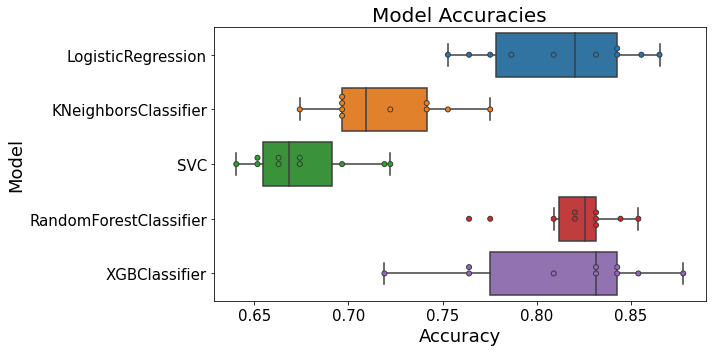

In [81]:
# Call the function plot_model_accuracies from the plot_functions.py file
plot_functions.plot_model_accuracies(results)

<div class="alert alert-block alert-success">
<strong><u>Analysis:</u></strong><br><br>The models that perform better without any hyperparameter tuning are the <i>Random Forest Classifier</i> and <i>XGBoost Classifier</i>. Therefore, they will be tuned to see which one performs better after tuning the hyperparameters.</div>

# <div style="color:white;display:fill;border-radius:5px;background-color:#015447;letter-spacing:0.1px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;text-align:center">Hyperparameter tuning</p></div>

The best classifiers will be tuned using the *GridSearchCV* method from the *scikit-learn* library.

In [88]:
# Initialize the classifiers that will be tuned
classifiers = [
                RandomForestClassifier(),
                XGBClassifier(use_label_encoder = False, verbosity = 0, silent = True)
              ]

# Set up parameter grids to search for each classifier.
param_grids = [
    { # Random forest Classifier
        'max_depth': np.arange(5, 20, 1),
        'min_samples_leaf': np.arange(2, 11, 1),
        'min_samples_split': np.arange(2, 11, 1),
        'n_estimators': [50, 100, 250, 500, 1000],
        'max_features': ['sqrt'],
        'random_state': [42]
    },
    { # XGBoost Classifier
        'max_depth': np.arange(5, 20, 1),
        'learning_rate': [0.01, 0.1, 1],
        'n_estimators': [50, 100, 250, 500, 1000],
        'lambda': [0, 0.01, 0.1, 1],
        'random_state': [42]
    }
]

In [89]:
# Call the function hyper_parameter_tuning from the utils.py file
utils.hyperparameter_tuning(classifiers, X_train, y_train, param_grids, 10)

Fitting 10 folds for each of 900 candidates, totalling 9000 fits


/home/albert/anaconda3/envs/datasci/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/albert/anaconda3/envs/datasci/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/albert/anaconda3/envs/datasci/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/albert/anaconda3/envs/datasci/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be remove

KeyboardInterrupt: 

### <b><span style='color:#015447'>Learning curves</span> </b>

We will plot the learning curves for each model to see which one performs better.

FileNotFoundError: [Errno 2] No such file or directory: 'models/grid_search_XGBClassifier.pkl'

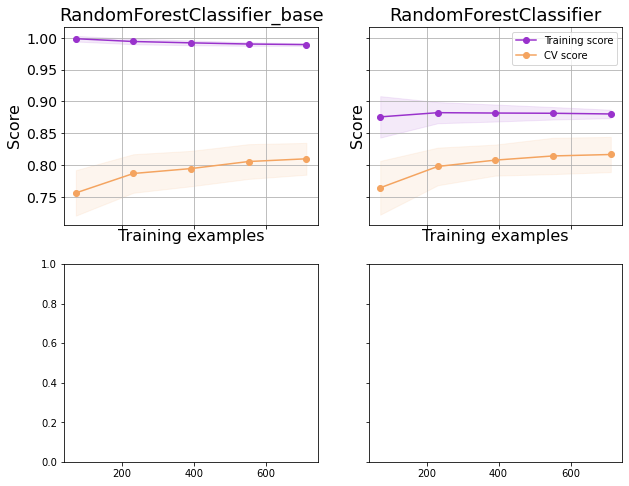

In [87]:
# Call the function plot_learning_curves from the plot_functions.py file
cv_results = plot_functions.plot_learning_curves(models=classifiers, X_train=X_train, 
                                                 y_train=y_train, cv_plot=10, cv_lc=None,
                                                 fig_size=(10, 8))

The learning curves show that both the <i>Random Forest Classifier</i> and <i>XGBoost Classifier</i> perform better after tuning the hyperparameters.

We can plot the accuracies obtained for each fold:

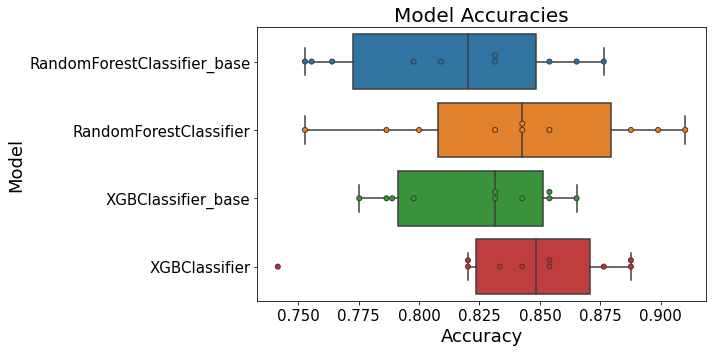

In [69]:
# Call the plot_model_accuracies function
plot_functions.plot_model_accuracies(cv_results)

It can be seen that the *XGBoost Classifier* performs better than the *Random Forest Classifier* on average after tuning the hyperparameters, but the difference is minimal.

### Model submission
We will now generate the predictions for the submission to the Kaggle competition for both the *Random Forest Classifier* and *XGBoost Classifier*.
We will also test the results of the models on the real data.

In [70]:
# Call the function model_submission from the utils.py file
utils.model_submission(classifiers, X_train, y_train, X_test)

Accuracy of RandomForestClassifier vs optimal submission is 0.868421052631579
Accuracy of XGBClassifier vs optimal submission is 0.8516746411483254


# Feature importance evaluation
We can check the importance of each feature in the different models obtained to see if we can improve the accuracies.

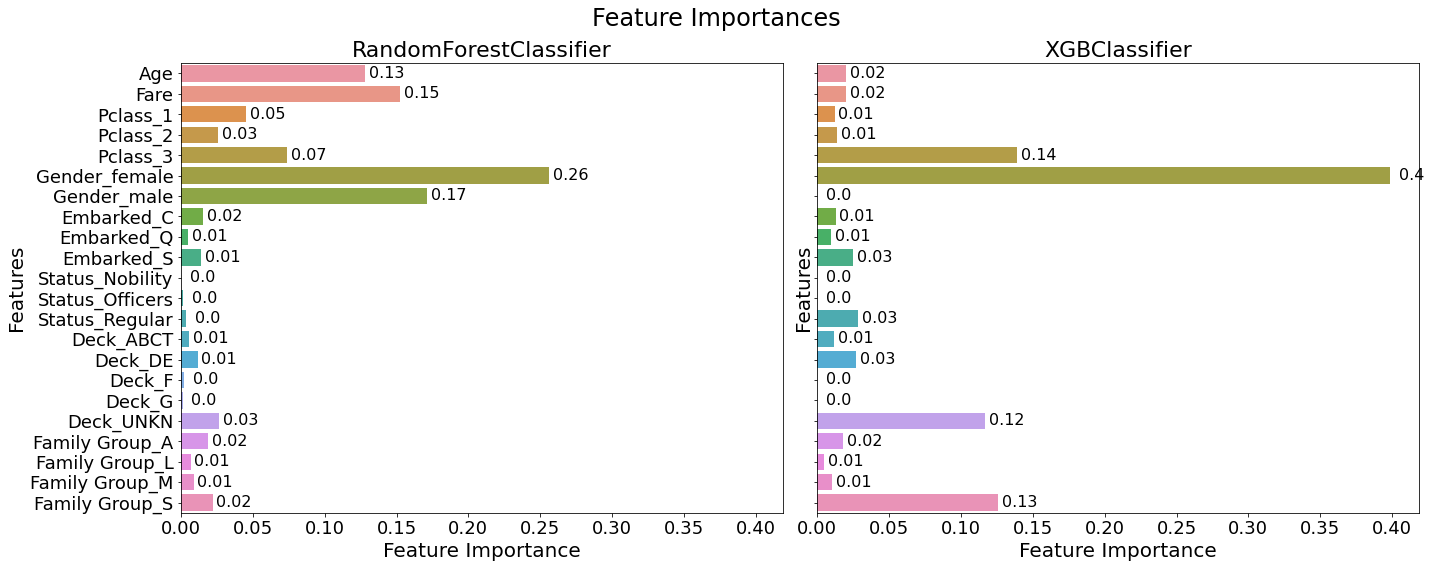

In [71]:
# Plot feature importances
predictions, feature_importances, models = plot_functions.plot_feature_importance(classifiers, X_test)

The gender is the class with highest influence to make predictions. While the *Age* and *Fare* are also very important in making predictions for the *Random Forest Classififer*, the *Pclass*, *Deck* and *Family Group* are quite important in making predictions for the *XGBoost Classifier*.

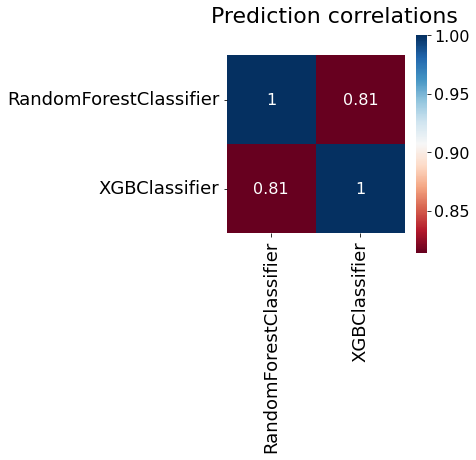

In [72]:
plot_functions.plot_prediction_correlation(predictions)

The prediction correlations between both models, although high, they are not 100% correlated. Therefore, the combination of models could be used to improve the accuracy of the predictions.

### Model combination
The strategy followed will be to use a voting classifier to decide which model predictions will be used to make the final predictions. We will also optimize the combined model by further hyperparameter tuning around the best parameters found using the *GridSearchCV* method for each individual model.

In [73]:
# Show the best parameters from the grid search for each classifier
utils.display_best_params(classifiers)

RandomForestClassifier best parameters:


{'max_depth': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 50}

XGBClassifier best parameters:


{'lambda': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Define the new parameter grids.

In [74]:
param_grids_loo = [
    { # Random Forest
        'max_depth': np.arange(6, 10, 1),
        'min_samples_leaf': np.arange(2, 5, 1),
        'min_samples_split': np.arange(6, 10, 1),
        'max_features': 'sqrt',
        'n_estimators': np.arange(50, 200, 25)
    },
    { # XGBoost
        'learning_rate': np.arange(0.01, 0.2, 0.02),
        'max_depth': np.arange(4, 8, 1),
        'n_estimators': np.arange(50, 200, 25),
        'lambda': np.arange(0, 2, 0.2)
    }
]

Perform leave-one-out cross-validation for each model.

In [75]:
# Perform LOO cross validation on all models
utils.leave_one_out_cv(classifiers, X_train, y_train, param_grids_loo)

Fitting 891 folds for each of 2400 candidates, totalling 2138400 fits


/home/albert/anaconda3/envs/datasci/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/albert/anaconda3/envs/datasci/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/albert/anaconda3/envs/datasci/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/albert/anaconda3/envs/datasci/lib/python3.9/site-packages/xgboost/data.py:262: Future

### Model submission
We will now generate the predictions for the submission to the Kaggle competition for both the *Random Forest Classifier* and *XGBoost Classifier* using the Leave-One-Out cross-validation.
We will also test the results of the models on the real data.

In [ ]:
# Get predictions from the models
utils.model_submission_loo(classifiers, X_train, y_train, X_test)

In [ ]:
# Create a combined model using the Random Forest and XGBoost classifiers
combined_model = VotingClassifier(estimators=classifiers, voting='hard')

